660710761 ธีมาพร เรืองศรี

week7-assignment

In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('/content/cafethai_prices.csv', parse_dates=['date'], date_format='%d/%m/%Y')
display(df.head())

,date,time,cash_type,coffee_name,money
0,2023-03-01,08:04:19,card,Latte,75
1,2023-03-01,08:08:54,cash,Americano with Milk,70
2,2023-03-01,08:09:03,card,Cappuccino,75
3,2023-03-01,08:10:26,cash,Cappuccino,75
4,2023-03-01,08:15:37,cash,Cappuccino,75


In [5]:
# รวมยอดจำนวนแก้วต่อวันต่อกาแฟ
daily_sales = df.groupby(['date', 'coffee_name']).size().reset_index(name='cups')
print(daily_sales.head(16))

         date          coffee_name  cups
0  2023-03-01            Americano    19
1  2023-03-01  Americano with Milk    27
2  2023-03-01           Cappuccino    24
3  2023-03-01                Cocoa     7
4  2023-03-01              Cortado    14
5  2023-03-01             Espresso     6
6  2023-03-01        Hot Chocolate     4
7  2023-03-01                Latte    24
8  2023-03-02            Americano    19
9  2023-03-02  Americano with Milk    26
10 2023-03-02           Cappuccino    18
11 2023-03-02                Cocoa     8
12 2023-03-02              Cortado     8
13 2023-03-02             Espresso     8
14 2023-03-02        Hot Chocolate     7
15 2023-03-02                Latte    31


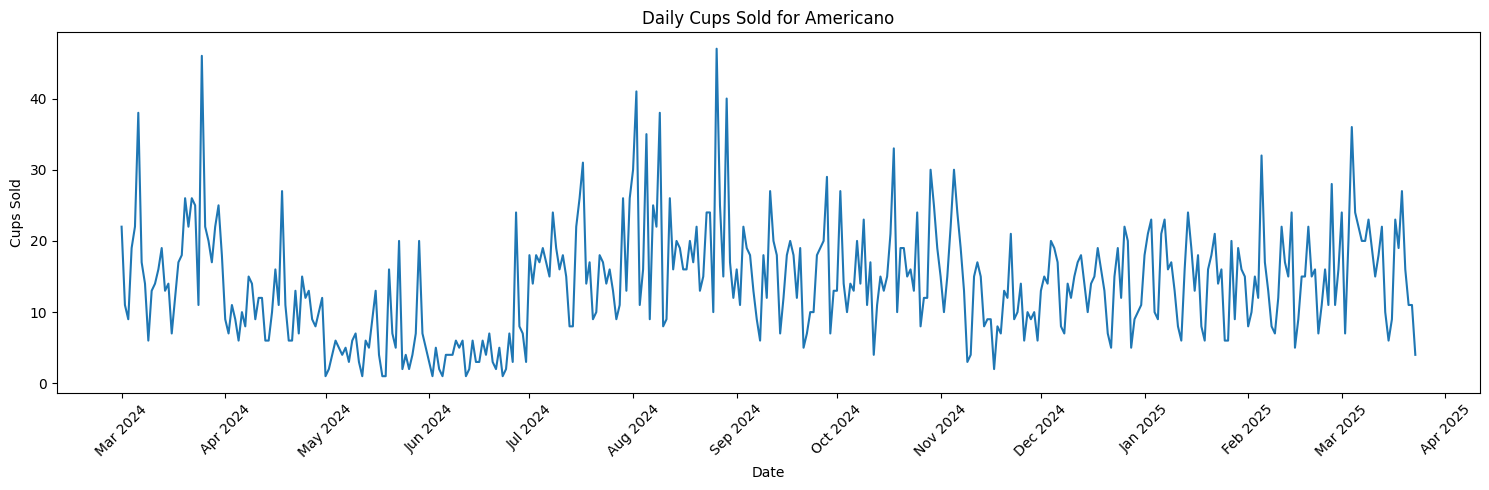

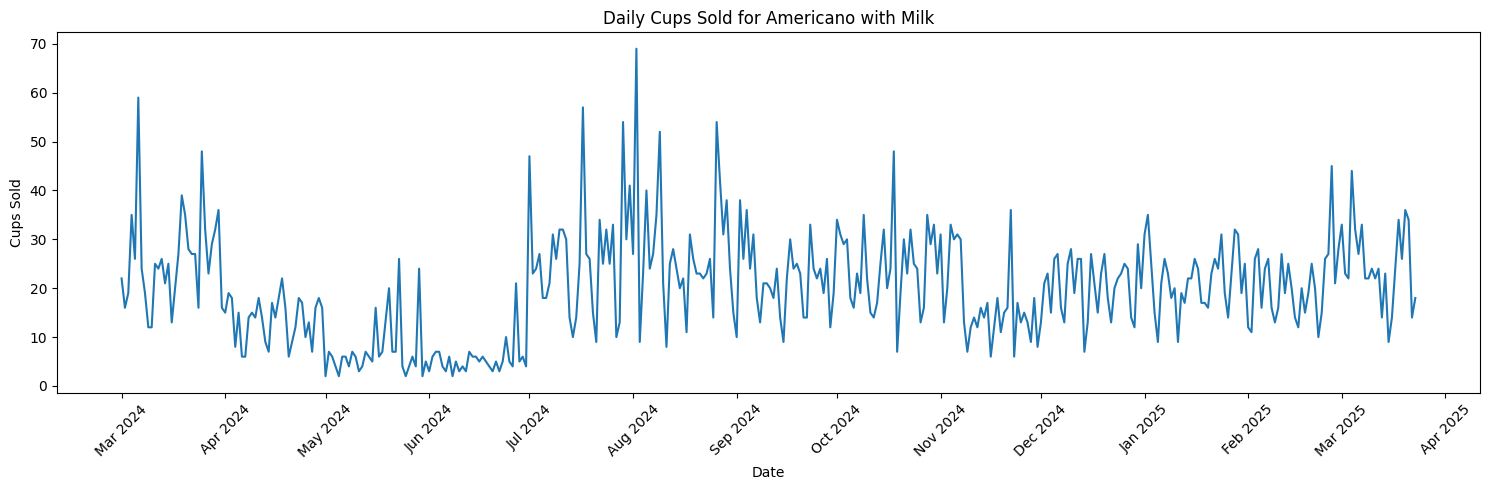

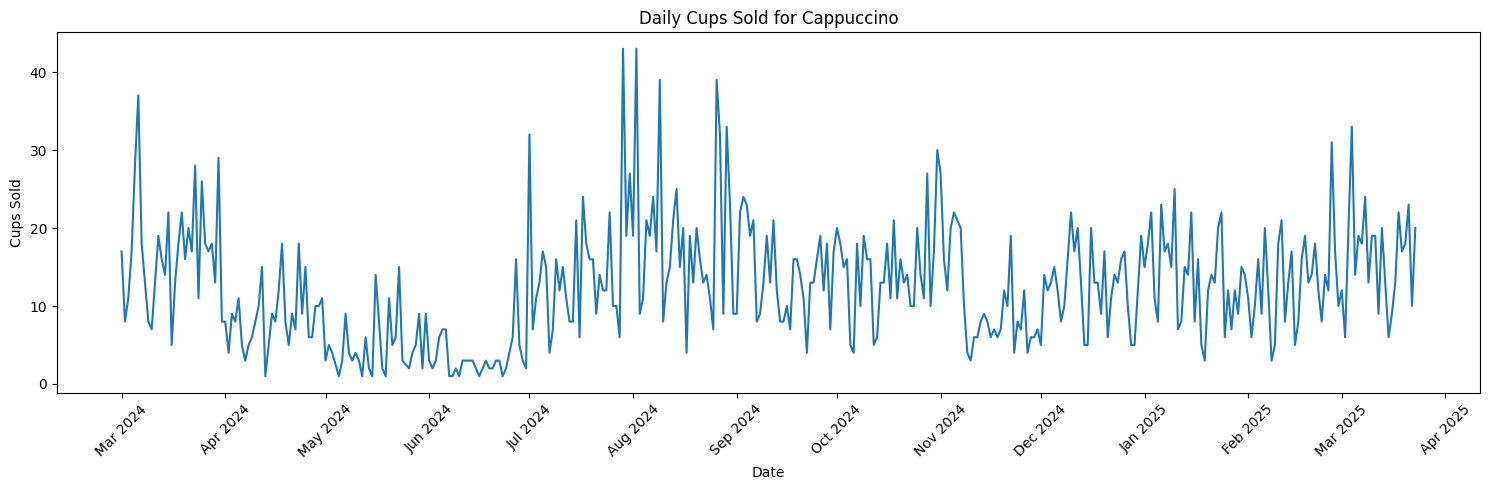

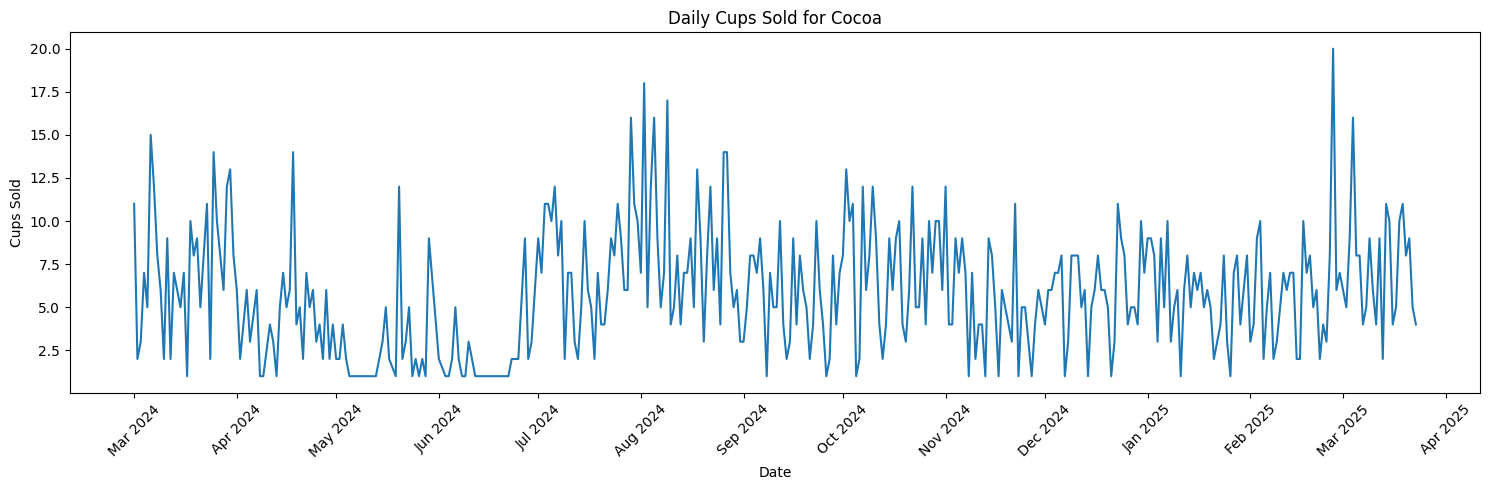

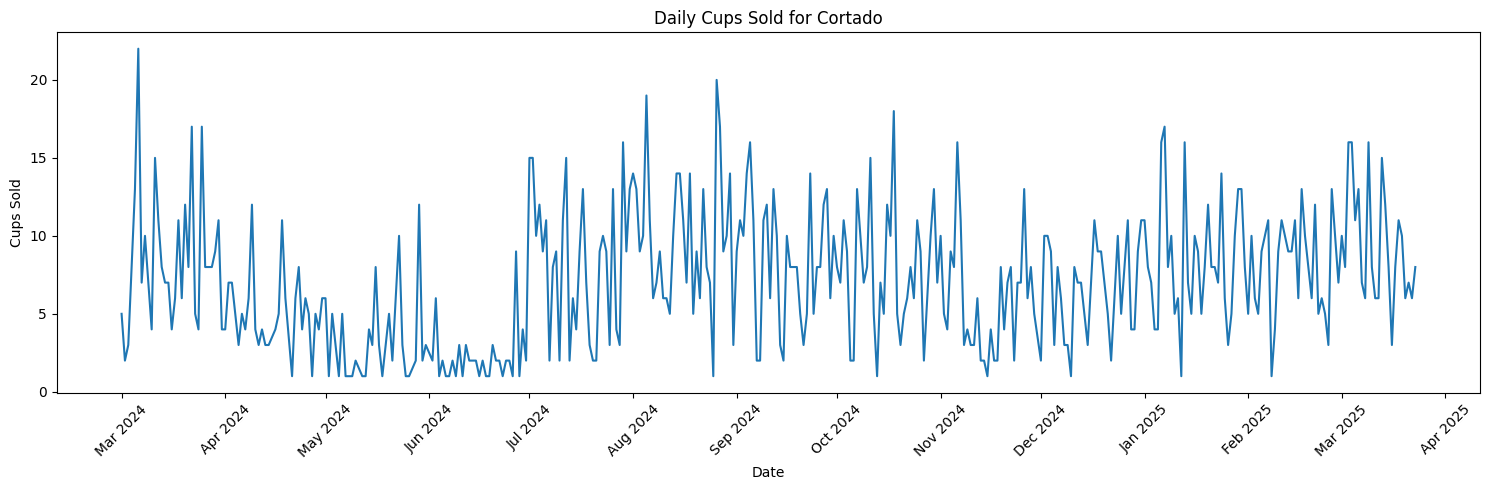

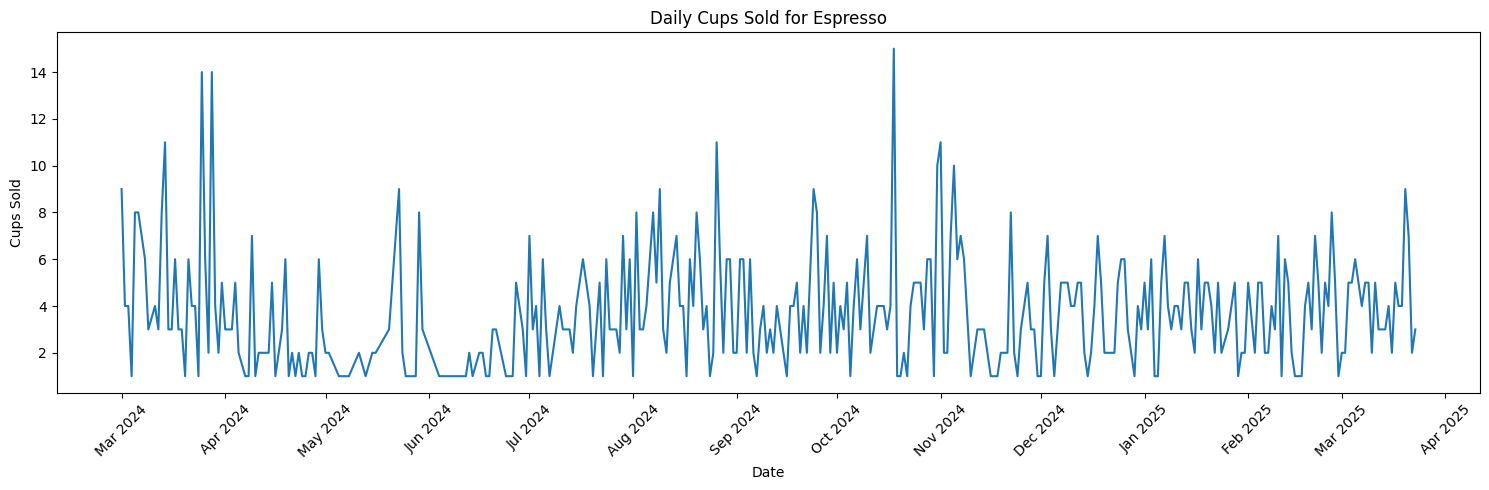

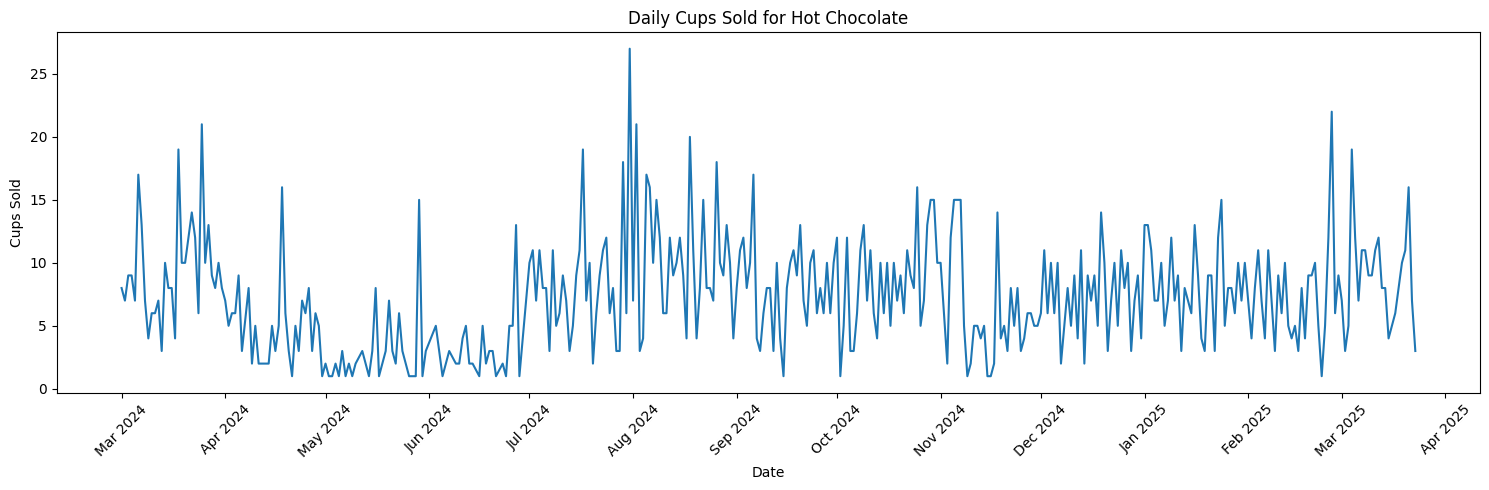

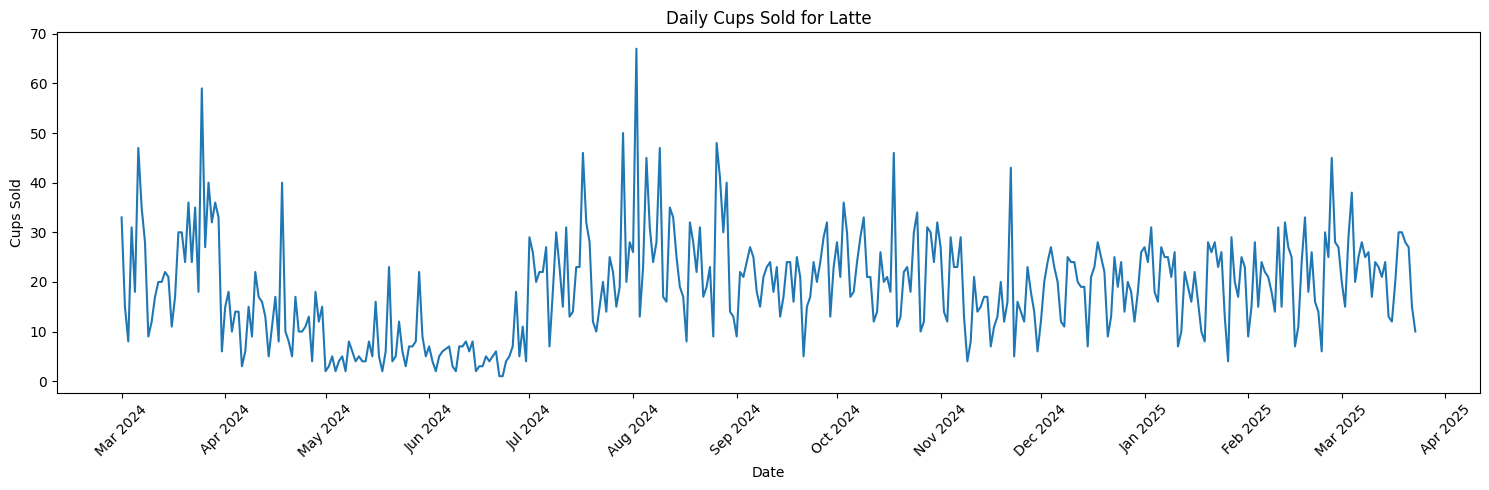

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# สร้าง daily_sales ใหม่ เป็นจำนวนแก้ว (นับจำนวนแถว)
daily_sales = df.groupby(['date', 'coffee_name']).size().reset_index(name='cups')

for coffee_name in daily_sales['coffee_name'].unique():
    coffee_sales = daily_sales[daily_sales['coffee_name'] == coffee_name].copy()  # copy เพื่อเลี่ยง Warning

    # Ensure date is datetime
    if not pd.api.types.is_datetime64_any_dtype(coffee_sales['date']):
        coffee_sales['date'] = pd.to_datetime(coffee_sales['date'], format='%d/%m/%Y', errors='coerce')

    coffee_sales.dropna(subset=['date'], inplace=True)  # ลบ row ที่วันที่ไม่ถูกต้อง

    # Filter date range
    start_date = '2024-03-01'
    end_date = '2025-03-23'
    coffee_sales = coffee_sales[(coffee_sales['date'] >= start_date) & (coffee_sales['date'] <= end_date)]

    coffee_sales.set_index('date', inplace=True)

    # Plot
    plt.figure(figsize=(15, 5))
    plt.plot(coffee_sales.index, coffee_sales['cups'])
    plt.title(f'Daily Cups Sold for {coffee_name}')
    plt.xlabel('Date')
    plt.ylabel('Cups Sold')

    # Format x-axis as month-year
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %Y'))
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [7]:
def create_sales_features(df):
    # Ensure date is datetime and set as index
    if not pd.api.types.is_datetime64_any_dtype(df['date']):
        df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y', errors='coerce')

    df.set_index('date', inplace=True)

    # Create features from date
    df['dayofweek'] = df.index.dayofweek  # 0 = Monday, 6 = Sunday
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['dayofyear'] = df.index.dayofyear
    df['year'] = df.index.year  # Add year feature

    # Sort by date before creating lag features
    df.sort_index(inplace=True)

    # Create Lag Features (previous cups sold)
    df['lag_7'] = df['cups'].shift(7)
    df['lag_14'] = df['cups'].shift(14)

    # Create Rolling Mean
    df['rolling_mean_7'] = df['cups'].shift(1).rolling(window=7).mean()

    # Reset index to make date a column again
    df.reset_index(inplace=True)

    return df


# ใช้ฟังก์ชันกับ daily_total_cups (ต้องสร้างมาก่อนจากการ groupby)
daily_total_cups_features = create_sales_features(daily_sales.copy())

# Drop rows with NaN values created by lag features
daily_total_cups_features.dropna(inplace=True)

display(daily_total_cups_features.head())


,date,coffee_name,cups,dayofweek,quarter,month,dayofyear,year,lag_7,lag_14,rolling_mean_7
14,2023-03-02,Hot Chocolate,7,3,1,3,61,2023,24.0,19.0,15.857143
15,2023-03-02,Latte,31,3,1,3,61,2023,19.0,27.0,13.428571
16,2023-03-03,Americano,19,4,1,3,62,2023,26.0,24.0,15.142857
17,2023-03-03,Americano with Milk,27,4,1,3,62,2023,18.0,7.0,14.142857
18,2023-03-03,Cappuccino,16,4,1,3,62,2023,8.0,14.0,15.428571


In [8]:
# Convert 'date' column to datetime objects
# Ensure 'date' is a column first if it was set as index
if df.index.name == 'date':
    df.reset_index(inplace=True)

df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y', errors='coerce')

# Display the data types to confirm the conversion
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68359 entries, 0 to 68358
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         68359 non-null  datetime64[ns]
 1   time         68359 non-null  object        
 2   cash_type    68359 non-null  object        
 3   coffee_name  68359 non-null  object        
 4   money        68359 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 2.6+ MB


None

In [9]:
FEATURES = ['dayofweek', 'quarter', 'month', 'dayofyear', 'lag_7', 'lag_14', 'rolling_mean_7']
TARGET = 'cups'   # เปลี่ยนจาก total_sales → cups

X = daily_total_cups_features[FEATURES]
y = daily_total_cups_features[TARGET]


In [10]:
# กำหนดวันแบ่งข้อมูล
split_date = '2025-03-01'

# แปลง 'date' เป็น datetime
daily_total_cups_features['date'] = pd.to_datetime(daily_total_cups_features['date'])

# แบ่งข้อมูลเป็น train และ test ตามวันที่
train_data = daily_total_cups_features[daily_total_cups_features['date'] < split_date]
test_data = daily_total_cups_features[daily_total_cups_features['date'] >= split_date]

X_train = train_data[FEATURES]
y_train = train_data[TARGET]
X_test = test_data[FEATURES]
y_test = test_data[TARGET]

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (5675, 7)
Shape of y_train: (5675,)
Shape of X_test: (482, 7)
Shape of y_test: (482,)


In [11]:
# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [12]:
# XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100,
                             learning_rate=0.05, # ค่อยๆ เรียนรู้ช้าๆ
                             early_stopping_rounds=10, # ถ้าผลไม่ดีขึ้น 10 รอบให้หยุด
                             random_state=42)

In [13]:
# XGBoost ต้องมี evaluation set เพื่อใช้ early stopping
xgb_model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [14]:
rf_pred = rf_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)

In [15]:
rf_mae = mean_absolute_error(y_test, rf_pred)
xgb_mae = mean_absolute_error(y_test, xgb_pred)

In [16]:
print(f"\nความคลาดเคลื่อนเฉลี่ยของ Random Forest: {rf_mae:.2f} จากทั้งหมด {len(y_test)} จุดข้อมูล")
print(f"ความคลาดเคลื่อนเฉลี่ยของ XGBoost: {xgb_mae:.2f} จากทั้งหมด {len(y_test)} จุดข้อมูล")
print(f"ยอดขายรวมใน Test Set: {y_test.sum():.2f} บาท")


ความคลาดเคลื่อนเฉลี่ยของ Random Forest: 4.68 จากทั้งหมด 482 จุดข้อมูล
ความคลาดเคลื่อนเฉลี่ยของ XGBoost: 4.74 จากทั้งหมด 482 จุดข้อมูล
ยอดขายรวมใน Test Set: 5407.00 บาท


In [17]:
results = pd.DataFrame({
    'Actual': y_test,
    'Random Forest': rf_pred,
    'XGBoost': xgb_pred
})

# Set the index of the results DataFrame to the dates from the test set
results.index = test_data['date']

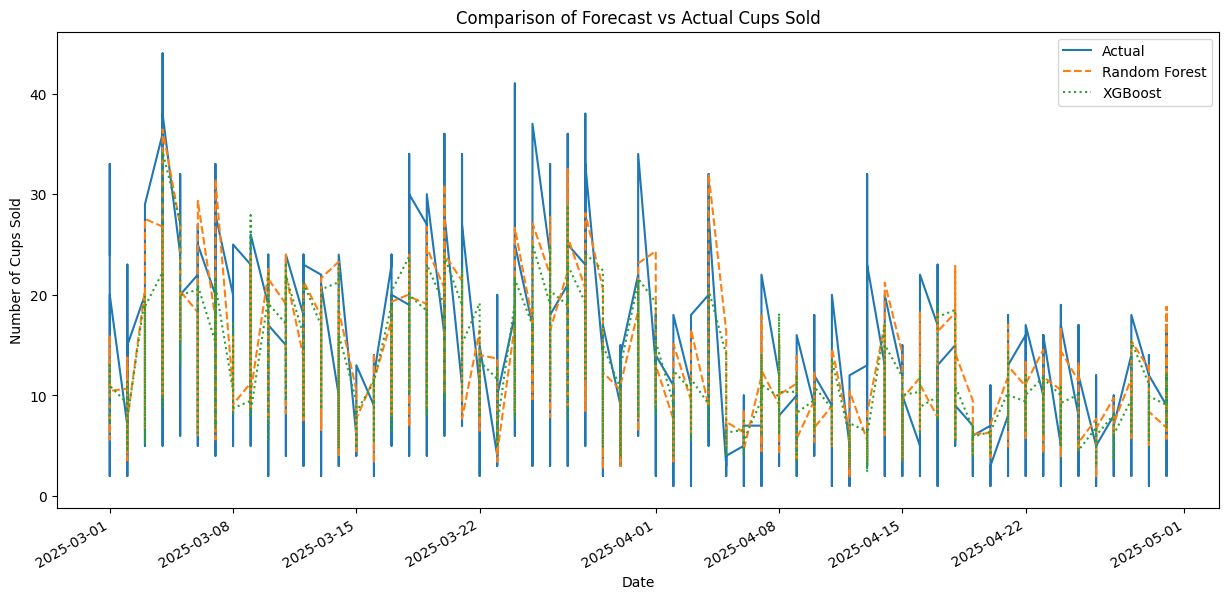

In [18]:
results.plot(figsize=(15, 7), style=['-', '--', ':'],
             title='Comparison of Forecast vs Actual Cups Sold')  # title
plt.ylabel('Number of Cups Sold')  # ylabel
plt.xlabel('Date')
plt.legend()
plt.show()

In [19]:
def plot_feature_importance(model, features, model_name, target='cups'):
    # สร้าง DataFrame ของ feature importance
    fi = pd.DataFrame(data=model.feature_importances_,
                      index=features,
                      columns=['importance'])
    fi_sorted = fi.sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=fi_sorted.index, y=fi_sorted['importance'])
    plt.title(f'Feature Importance of the {model_name} Model for {target}')  # target
    plt.xticks(rotation=45)
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.show()

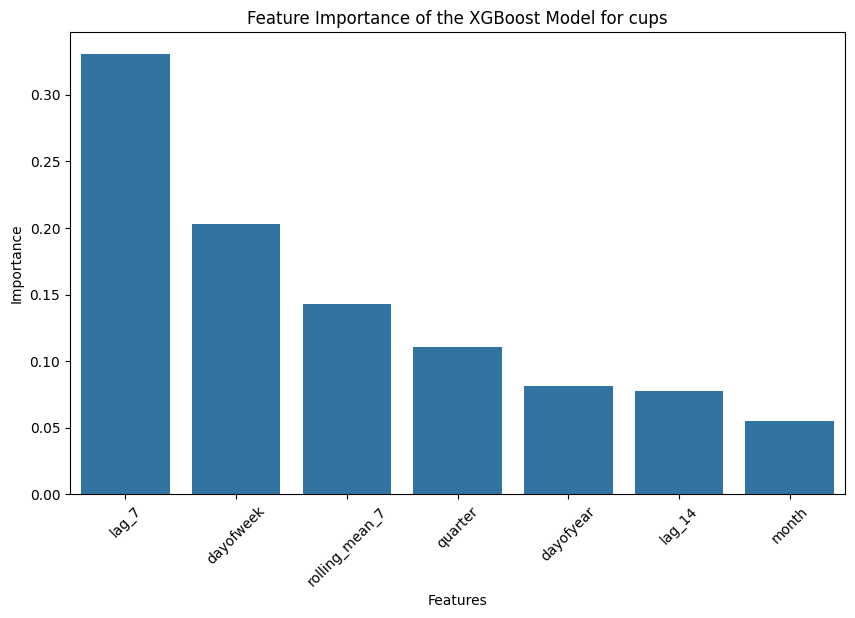

In [20]:
plot_feature_importance(xgb_model, FEATURES, 'XGBoost')

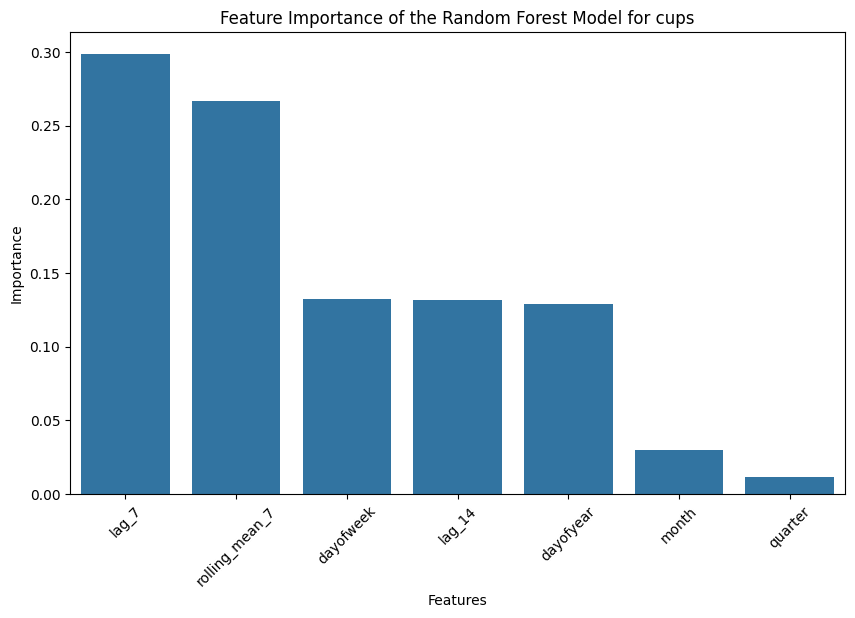

In [21]:
plot_feature_importance(rf_model, FEATURES, 'Random Forest')

prophet

In [22]:
!pip install prophet

In [23]:
from prophet import Prophet

In [24]:
# Prepare data for Prophet: requires 'ds' (datetime) and 'y' (target) columns
# Use the already split train_data and test_data DataFrames

# Add print statements to check columns
print("Columns in train_data:", train_data.columns)
print("Columns in test_data:", test_data.columns)

Columns in train_data: Index(['date', 'coffee_name', 'cups', 'dayofweek', 'quarter', 'month',
       'dayofyear', 'year', 'lag_7', 'lag_14', 'rolling_mean_7'],
      dtype='object')
Columns in test_data: Index(['date', 'coffee_name', 'cups', 'dayofweek', 'quarter', 'month',
       'dayofyear', 'year', 'lag_7', 'lag_14', 'rolling_mean_7'],
      dtype='object')


In [25]:
prophet_train = train_data[['date', 'cups']].rename(columns={'date': 'ds', 'cups': 'y'})
prophet_test = test_data[['date', 'cups']].rename(columns={'date': 'ds', 'cups': 'y'})


In [26]:
# Initialize and fit the Prophet model
model = Prophet(weekly_seasonality=True,yearly_seasonality=True)
model.fit(prophet_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn9dbybfq/90ltq1no.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn9dbybfq/fb4dwq9j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10978', 'data', 'file=/tmp/tmpn9dbybfq/90ltq1no.json', 'init=/tmp/tmpn9dbybfq/fb4dwq9j.json', 'output', 'file=/tmp/tmpn9dbybfq/prophet_modeliekn7xv1/prophet_model-20250920081044.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:10:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:10:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [27]:
# Display the index (dates) of the RF/XGBoost test set
display(y_test.index)

Index([5689, 5690, 5691, 5692, 5693, 5694, 5695, 5696, 5697, 5698,
       ...
       6161, 6162, 6163, 6164, 6165, 6166, 6167, 6168, 6169, 6170],
      dtype='int64', length=482)

In [28]:
# Create a future dataframe for predictions
# We need to predict for the dates in the test set
future = model.make_future_dataframe(periods=len(prophet_test))

In [29]:
# Make predictions
forecast = model.predict(future)

In [30]:
# Display the forecast
display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

,ds,yhat,yhat_lower,yhat_upper
0,2023-03-02,14.241187,4.176395,24.713774
1,2023-03-03,13.712263,3.661252,24.132250
2,2023-03-04,8.443879,-1.826771,18.680092
3,2023-03-05,8.729584,-1.052198,19.128094
4,2023-03-06,14.675460,5.109717,25.078560


In [31]:
# Evaluate the Prophet model
# Merge actual values with forecast
prophet_results = forecast.set_index('ds')[['yhat']].join(prophet_test.set_index('ds')[['y']])
prophet_results.dropna(inplace=True) # Drop rows where there are no actual values (if future was longer than test)

In [32]:
# Calculate MAE
prophet_mae = mean_absolute_error(prophet_results['y'], prophet_results['yhat'])

print(f"ความคลาดเคลื่อนเฉลี่ยของ Prophet: {prophet_mae:.2f} จากทั้งหมด {len(prophet_results)} จุดข้อมูล")
print(f"จำนวนแก้วรวมใน Test Set (สำหรับ Prophet): {prophet_results['y'].sum():.0f} แก้ว")


ความคลาดเคลื่อนเฉลี่ยของ Prophet: 5.95 จากทั้งหมด 482 จุดข้อมูล
จำนวนแก้วรวมใน Test Set (สำหรับ Prophet): 5407 แก้ว


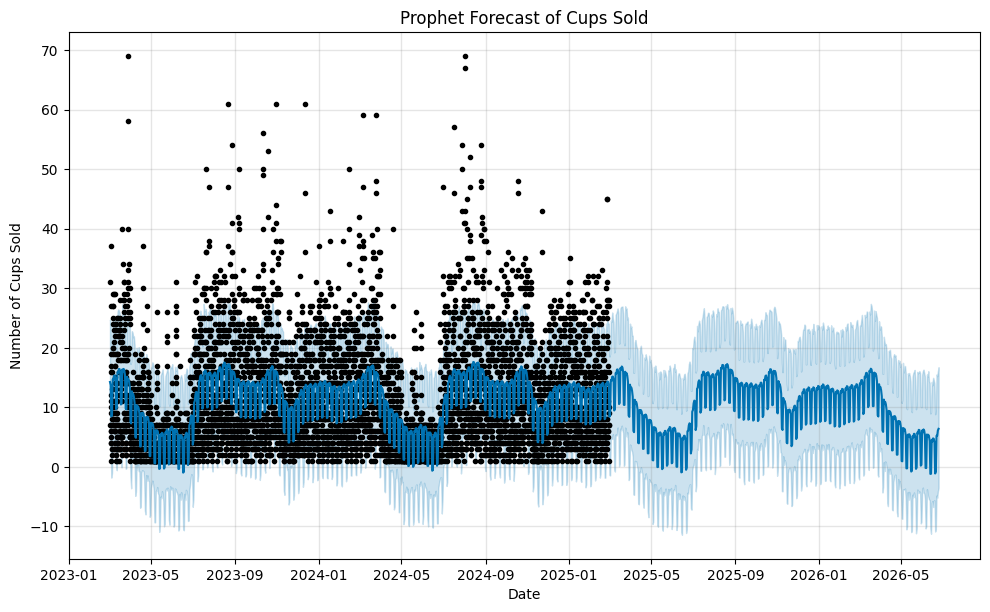

In [33]:
# Plot the forecast
fig1 = model.plot(forecast)
plt.title('Prophet Forecast of Cups Sold')  # เปลี่ยน title
plt.xlabel('Date')
plt.ylabel('Number of Cups Sold')  # เปลี่ยน ylabel
plt.show()

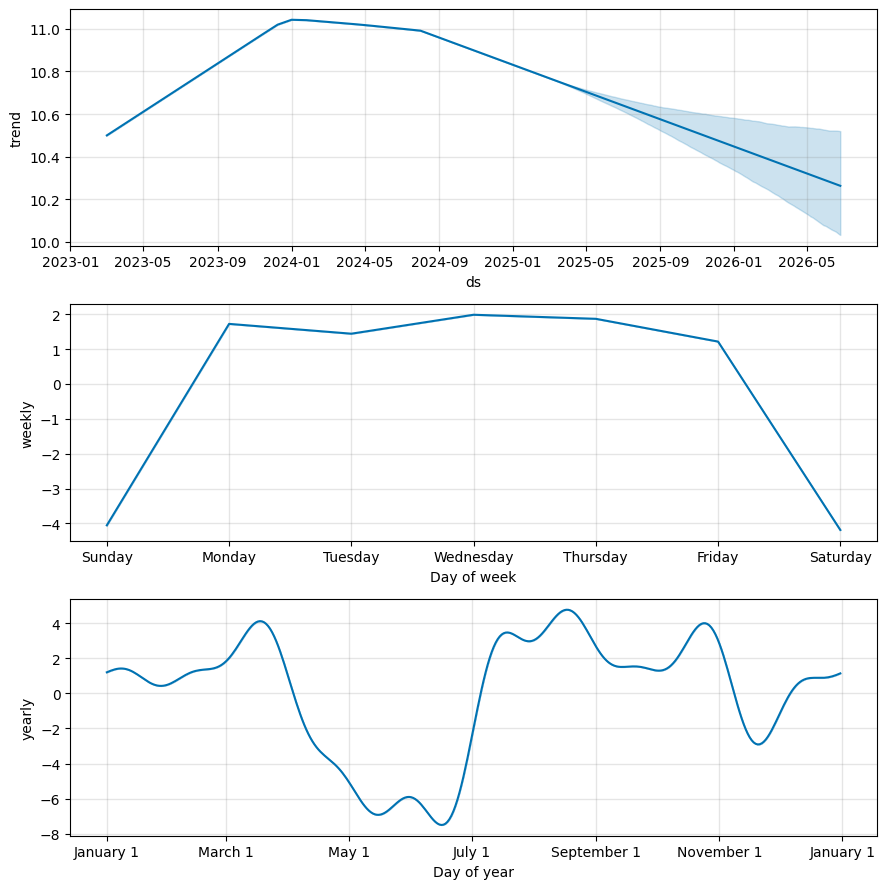

In [34]:
# Plot the components of the forecast
fig2 = model.plot_components(forecast)
plt.show()

chronos

In [35]:
pip install git+https://github.com/amazon-science/chronos-forecasting.git

  Cloning https://github.com/amazon-science/chronos-forecasting.git to /tmp/pip-req-build-r1ow3b6m
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /tmp/pip-req-build-r1ow3b6m
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit fcd09fe8b6bf57643bde7847bf42a6719b7ee205
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for chronos-forecasting: filename=chronos_forecasting-1.5.3-py3-none-any.whl size=29457 sha256=1ed17963a7cb042bbb2bbd927e0f5c26133b09dc77300086832dedd8cf911cd2
  Stored in directory: /tmp/pip-ephem-wheel-cache-4r_jxac0/wheels/b9/a6/b5/75fca7306751a3bc92a63680f861f44a42a8776f6423cf0188
Successfully built chronos-forecasting


In [36]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from chronos import ChronosPipeline

In [37]:
pipeline = ChronosPipeline.from_pretrained(
  "amazon/chronos-t5-small",
  device_map="cuda",
  dtype=torch.bfloat16,
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/185M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

In [39]:
# Prepare the data for Chronos
# Chronos expects a torch tensor as input. We'll use the 'cups' column
# Filter data before the split date
split_date = pd.to_datetime('2025-03-01')
historical_cups_before_split = daily_sales[daily_sales['date'] < split_date].copy()

# Convert the 'cups' column from the filtered data to a torch tensor
context = torch.tensor(historical_cups_before_split['cups'].values)

# Define the prediction length (e.g., 60 days for one month forecast)
prediction_length = 60

# Make a forecast using the Chronos pipeline
forecast = pipeline.predict(context, prediction_length)

# The forecast is a distribution. We can get the median prediction.
# The forecast tensor will have shape (num_samples, prediction_length)
# We take the median along the sample dimension (dim=0)
median_prediction = forecast[0].median(dim=0).values

# Display the median prediction
print(f"Chronos Median Forecast for the next {prediction_length} days (in cups):")
display(median_prediction)


Chronos Median Forecast for the next 60 days (in cups):


tensor([15.9949, 18.9666,  9.9640,  6.9923,  6.9923,  4.0206,  6.9923, 15.9949,
        15.0334, 15.9949,  9.9640,  8.0411,  6.0309,  4.9820,  9.0026, 20.0155,
        18.0052, 19.0540,  9.0026,  6.9923,  4.9820,  4.9820, 15.0334, 20.9769,
        22.9872, 22.0258, 13.9846, 13.0232,  8.0411, 11.9743, 22.0258, 22.9872,
        15.9949, 20.8895, 15.9949,  8.0411,  9.9640,  6.9923, 11.9743, 20.0155,
        18.0052, 18.7918, 13.0232,  6.9923,  6.9923,  5.5064,  9.0026, 15.9949,
        20.0155, 13.0232,  6.9923,  4.9820,  6.0309,  9.9640, 11.9743, 15.0334,
        15.9949, 13.9846, 11.9743,  8.0411])

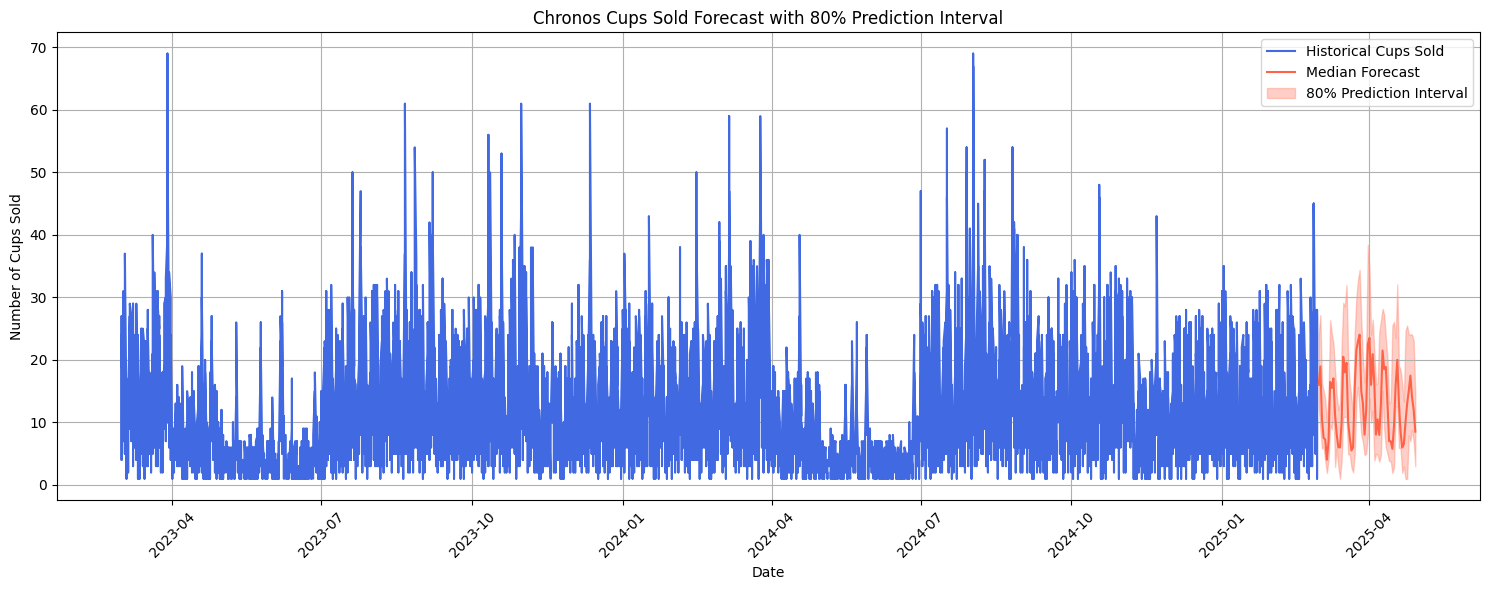

In [40]:
# Visualize the Chronos forecast with prediction interval
plt.figure(figsize=(15, 6))

# Plot historical data (daily_total_sales before split_date)
plt.plot(historical_cups_before_split['date'], historical_cups_before_split['cups'],
         color="royalblue", label="Historical Cups Sold")

# Create dates for the forecast period
# The forecast starts immediately after the last date in the historical_cups_before_split
last_date_historical = historical_cups_before_split['date'].iloc[-1]
forecast_dates = pd.date_range(start=last_date_historical + pd.Timedelta(days=1),
                               periods=prediction_length, freq='D')

# Calculate quantiles for the prediction interval
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

# Plot the median forecast
plt.plot(forecast_dates, median, color="tomato", label="Median Forecast")

# Plot the 80% prediction interval
plt.fill_between(forecast_dates, low, high, color="tomato", alpha=0.3, label="80% Prediction Interval")

plt.title('Chronos Cups Sold Forecast with 80% Prediction Interval')  # เปลี่ยน title
plt.xlabel('Date')
plt.ylabel('Number of Cups Sold')  # เปลี่ยน ylabel
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [41]:
forecast[0][:][0]

tensor([11.0129, 18.0052,  9.0026, 22.0258, 22.0258, 24.0360, 13.9846, 22.0258,
        21.0643,  4.9820,  4.9820, 26.0463, 15.9949, 22.9872, 15.9949, 11.9743,
        13.9846,  2.0103,  4.0206, 16.9563,  9.0026, 28.0566, 26.0463, 13.9846,
        13.0232,  4.0206,  8.0411, 22.9872, 37.9332, 22.0258, 22.9872, 22.0258,
         6.0309, 11.0129,  4.0206,  4.9820, 23.9486,  9.0026, 20.0155, 15.0334,
         9.0026, 20.0155,  4.9820,  4.0206,  6.9923,  5.5064, 27.0952, 15.9949,
        33.0386, 18.9666, 22.9872, 27.9692, 20.0155, 18.9666, 24.9975, 24.8227,
        18.9666, 24.0360, 24.0360, 11.9743])

In [42]:
median_forecast = np.median(forecast[0], axis=0)
print("ค่ามัธยฐานของผลการพยากรณ์จำนวนแก้ว 12 เดือนข้างหน้า")
print(median_forecast)

ค่ามัธยฐานของผลการพยากรณ์จำนวนแก้ว 12 เดือนข้างหน้า
[15.994891  18.96662   10.488453   7.5167246  7.2545137  4.0205736
  6.9923024 16.47561   15.51417   17.043736  11.231385   8.041147
  6.0308604  5.987159  10.007732  20.496185  18.005178  19.534744
 10.007732   7.5167246  5.5064383  5.987159  15.51417   21.501328
 22.987194  24.036037  14.989748  13.023163   8.041147  12.018019
 22.506474  23.511616  15.994891  20.933205  15.994891   8.041147
 10.488453   7.997446  12.979461  21.50133   18.485899  18.879215
 13.023163   6.9923024  6.9923024  5.768649   9.483311  15.994891
 20.015465  13.023163   8.478167   5.987159   6.5115814  9.964031
 12.979461  15.033449  17.480755  13.984604  12.018019   8.521868 ]
